# 9. 분류 실습 - 캐글 신용카드 사기 검출

Kaggle의 신용카드 데이터 세트를 이용해 신용카드 사기 검출 분류 실습을 수행해 보자.

데이터는 https://www.kaggle.com/mlg-ulb/creditcardfraud 에서 내려받을 수 있다. 캐글에 로그인한 후 해당 웹 페이지에서 'Download(66 MB)'를 클릭하면 creditcard.csv 파일이 포함된 압축 파일을 내려받을 수 있다(캐글 경연 규칙 준수 화면으로 이동할 경우 해당 규칙 준수에 동의하면 된다). 내려받은 압축 파일을 풀어서 creditcard.csv 파일을 PC의 적당한 위치에 저장한다.

해당 데이터 세트의 레이블인 Class 속성은 매우 불균형한 분포를 가지고 있다. Class는 0과 1로 분류되는데 0이 사기가 아닌 정상적인 신용카드 트랜잭션 데이터, 1은 신용카드 사기 트랜잭션을 의미한다. 전체 데이터의 약 0.172%만이 레이블 값이 1, 즉 사기 트랜잭션이다. 일반적으로 사기 검출(Fraud Detection)이나 검출(Anomaly Detection)과 같은 데이터 세트는 이처럼 레이블 값이 극도록 불균형한 분포를 가지기 쉽다. 왜냐하면 사기와 같은 이상 현상은 전체 데이터에서 차지하는 비중이 매우 적을 수밖에 없기 때문이다.

**언더 샘플링과 오버 샘플링의 이해**
레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생한다. 즉 이상 레이블을 가지는 데이터 건수는 매우 적기 때문에 제대로 다양한 유형을 학습하지 못하는 반면에 정상 레이블을 가지는 데이터 건수는 매우 많기 때문에 일방적으로 정상 레이블로 치우친 학습을 수행해 제대로 된 이상 데이터 검출이 어려워지기 쉽다. 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방법이 있으며, 오버 샘플링 방식이 예측 성능상 더 유리한 경우가 많아 주로 사용된다.
* 언더 샘플링 : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식. 정상 레이블을 가진 데이터가 10,000건, 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여 버리는 방식이다. 이렇게 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시키기 때문에 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않는 방법이다.
* 오버 샘플링 : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법이다. 동일한 데이터를 단순히 증식하는 방법은 과적합(Overfitting)이 되기 때문에 의미가 없으므로 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식한다. 대표적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법이 있다. SMOTE는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식이다.

SMOTE를 구현한 대표적인 파이썬 패키지는 imbalanced-learn이다. 이번 절에서는 이를 이용해 데이터를 증식해 보겠다. imbalanced-learn 패키지는 아나콘다를 이용해 설치가 가능하다. 아나콘다 프롬프트를 관리자 권한으로 실행하고 다음 명령어를 입력하면 자동으로 설치를 진행한다.

```conda install -c conda-forge imbalanced-learn```

**데이터 일차 가공 및 모델 학습/예측/평가**

설치가 됐으면 이제 데이터 세트를 로딩하고 신용카드 사기 검출 모델을 생성하겠다. 새로운 주피터 노트북을 생성하고, 다운로드 받은 creditcard.csv 파일을 동일한 디렉터리로 이동시킨 후 DataFrame으로 로딩한다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df=pd.read_csv("C:/Users/User/Desktop/2024-1/ESAA/creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


creditcard.csv의 V로 시작하는 피처들의 의미는 알 수가 없다.
* Time 피처의 경우는 데이터 생성 관련한 작업용 속성으로서 큰 의미가 없기에 제거한다.
* Amount 피처는 신용카드 트랜잭션 금액
* Class : 레이블로서 0의 경우 정상, 1의 경우 사기 트랜잭션이다.
  
card_df.info()로 확인해보면 전체 284,807개의 레코드에서 결측치(Missing Value) 값은 없으며, Class 레이블만 int형이고 나머지 피처들은 모두 float형이다.

이번 실습에서는 보다 다양한 데이터 사전 가공을 수행하고, 이에 따른 예측 성능도 함께 비교해 보겠다. 이를 위해 인자로 입력된 DataFrame을 복사한 뒤, 이를 가공하여 반환하는 get_preproceed_df() 함수와 데이터 가공 후 학습/테스트 데이터 세트를 반환하는 get_train_test_df() 함수를 생성하겠다. 먼저 get_preprocessed_df() 함수는 불필요한 Time 피처만 삭제하는 것으로부터 시작하겠다.

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사한 뒤 Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

get_train_test_dataset()는 get_preprocessed_df()를 호출한 뒤 학습 피처/레이블 데이터 세트, 테스트 피처/레이블 데이터 세트를 반환한다. get_train_test_dataset()은 내부에서 train_test_split() 함수를 호출하며, 테스트 데이터 세트를 전체의 30%인 Stratified 방식으로 추출해 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 분포도를 서로 동일하게 만든다.

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy=get_preprocessed_df(df)
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
    X_features=df_copy.iloc[:, :-1]
    y_target=df_copy.iloc[:, -1]
    # train_test_split()으로 학습과 테스트 데이터 분할, stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    #학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

생성한 학습 데이터 세트와 테스트 데이터 세트의 레이블 값 비율을 백분율로 환산해서 서로 비슷하게 분할됐는지 확인해 보자.

In [6]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


학습 데이터 레이블의 경우 1값이 약 0.172%, 테스트 데이터 레이블의 경우 1값이 약 0.173%로 큰 차이가 없이 잘 분할됐다. 이제 모델을 만들어 보겠다. 로지스틱 회귀와 LightGBM 기반의 모델이 데이터 가공을 수행하면서 예측 성능이 어떻게 변하는지 살펴볼 것이다. 먼저 로지스틱 회귀를 이용해 신용 카드 사기 여부를 예측해 보겠다. 예측 성능 평가는 3장에서 생성한 get_clf_eval() 함수를 다시 사용하겠다.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

In [13]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion=confusion_matrix(y_test, pred)
    accuracy=accuracy_score(y_test, pred)
    precision=precision_score(y_test, pred)
    recall=recall_score(y_test, pred)
    f1=f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc=roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [14]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:, 1]

# 3장에서 사용한 get_clf_eval() 함수를 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   60    88]]
정확도: 0.9991, 정밀도: 0.8713, 재현율: 0.5946, F1: 0.7068, AUC: 0.9592


테스트 데이터 세트로 측정 시 재현율(Recall)이 0.5946, ROC-AUC가 0.9592이다. 이번에는 LightGBM을 이용한 모델을 만들어 보겠다. 그에 앞서, 앞으로 수행할 예제 코드에서 반복적으로 모델을 변경해 학습/예측/평가할 것이므로 이를 위한 별도의 함수를 생성하겠다. get_model_trian_eval()은 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가를 수행하는 역할을 하는 함수이다.

In [15]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred=model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

먼저, 본 데이터 세트는 극도로 불균형한 레이블 값 분포도를 가지고 있으므로 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 한다.
* 주의 : LightGBM이 버전업되면서 boost_from_average 파라미터의 디폴트 값이 False에서 True로 변경되었다. 본 예제와 같이 레이블 값이 극도로 불균형한 분포를 이루는 경우 boost_from_average=True 설정은 재현률 및 ROC-AUC 성능을 매우 크게 저하시킨다. LightGBM 2.1.0 이상의 버전이 설치되어 있거나 불균형한 데이터 세트에서 예측 성능이 매우 저조할 경우 LGBMClassifier 객체 생성 시 boost_from_average=False로 파라미터를 설정해야 한다.

https://github.com/Microsoft/LightGBM/issues/1487 에 본 이슈에 대한 질의와 답변들이 있으미 참고하기 바란다.

LightGBM으로 모델을 학습한 뒤, 별도의 테스트 데이터 세트에서 예측 평가를 수행해 보겠다.

In [17]:
!pip install lightgbm==3.3.2

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.0 MB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 12.9 MB/s eta 0:00:00


In [18]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568, F1: 0.8453, AUC: 0.9790


재현율 0.7568, ROC-AUC 0.9790로 앞의 로지스틱 회귀보다는 높은 수치를 나타냈다.

**데이터 분포도 변환 후 모델 학습/예측/평가**
이번에는 왜곡된 분포도를 가지는 데이터를 재가공한 뒤에 모델을 다시 테스트해 보겠다. 먼저 creditcard.csv의 중요 피처 값의 분포도를 살펴보자. 5장에서 더 자세히 설명하겠지만, 로지스틱 회귀는 선형 모델이다. 대부분의 선형 모델은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호한다.
* Amount 피처는 신용 카드 사용 금액으로 정상/사기 트랜잭션을 결정하는 매우 중요한 속성일 가능성이 높다. Amount 피처의 분포도를 확인해 보겠다.

<Axes: xlabel='Amount', ylabel='Density'>

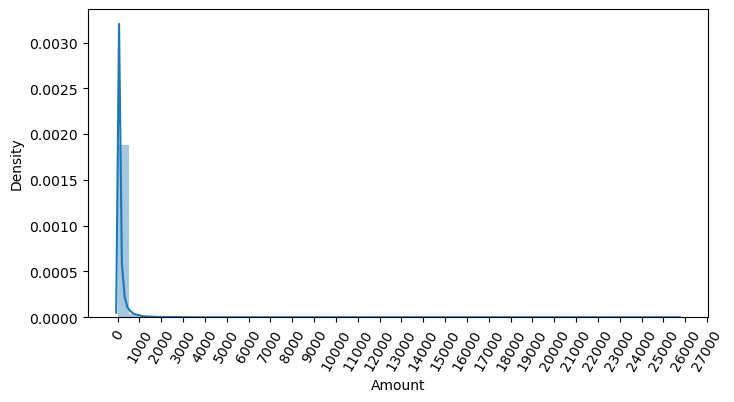

In [19]:
import seaborn as sns
plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])

Amount, 즉 카드 사용금액이 1000불 이하인 데이터가 대부분이며, 27,000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선을 가지고 있다. Amount를 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해 보겠다. 이를 위해 앞에서 만든 get_processed_df() 함수를 다음과 같이 사이킷런의 StandardScaler 클래스를 이용해 Amount 피처를 정규 분포 형태로 변환하는 코드로 변경한다.

In [20]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

함수를 수정한 후 get_train_test_dataset()를 호출해 학습/테스트 데이터 세트를 생성한 후에 get_model_train_eval()를 이용해 로지스틱 회귀와 LightGBM 모델을 각각 학습/예측/평가 해보겠다.

In [22]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081, F1: 0.7143, AUC: 0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85150   145]
 [  125    23]]
정확도: 0.9968, 정밀도: 0.1369, 재현율: 0.1554, F1: 0.1456, AUC: 0.5768


정규 분포 형태로 Amount 피처값을 변환한 후 테스트 데이터 세트에 적용한 로지스틱 회귀 및 LightGBM 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않았다.

이번에는 StandardScaler가 아니라 로그 변환을 수행해 보겠다. 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중에 하나이다. 원래 값을 log 값으로 변환해 원래 큰 값을 상대적으로 작은 값으로 변환하기 때문에 데이터 분포도의 왜곡을 상당 수준 개선해 준다. 다음 장인 5장에서 더 자세하게 다루겠다. 로그 변환은 넘파이의 log1p() 함수를 이용해 간단히 변환이 가능하다. 데이터 가공 함수인 get_preprocessed_df()를 다음과 같이 로그 변환 로직으로 변경한다.

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    # 넘파이의 log1p()을 이용해 Amount를 로그 변환
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

이제 Amount 피처를 로그 변환한 후 다시 로지스틱 회귀와 LightGBM 모델을 적용한 후 예측 성능을 확인해 보자.

In [25]:
X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014, F1: 0.7149, AUC: 0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85217    78]
 [   78    70]]
정확도: 0.9982, 정밀도: 0.4730, 재현율: 0.4730, F1: 0.4730, AUC: 0.7393


두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능이 개선되었음을 나타내고 있다.

**이상치 데이터 제거 후 모델 학습/예측/평가**

이상치 데이터(Outlier)는 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터이며, 아웃라이어라고도 불린다. 이상치로 인해 머신러닝 모델의 성능에 영향을 받는 경우가 발생하기 쉽다. 이번에는 이러한 이상치를 찾아내는 방법을 소개하고, 이들 데이터를 제거한 뒤에 다시 모델을 평가해 보겠다. 이상치를 찾는 방법은 여러 가지가 있지만, 이 중에서 IQR(Inter Quantile Range) 방식을 적용해 보겠다. IQR은 사분위(Quantile) 값의 편차를 이용하는 기법으로 흔히 박스 플롯(Box Plot) 방식으로 시각화할 수 있다.

먼저 사분위에 대해 알아보자. 사분위는 전체 데이터를 값이 높은 순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는 것을 지칭한다. 가령 100명의 시험 성적이 0점부터 100점까지 있다면, 이를 100등부터 1등까지 성적순으로 정렬한 뒤에 1/4 구간으로 Q1, Q2, Q3, Q4와 같이 나누는 것이다. IQR을 이용해 이상치 데이터를 검출하는 방식은 보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최솟값을 결정한 뒤 최댓값을 초과하거나 최솟값에 미달하는 데이터를 이상치로 간주하는 것이다. 3/4 분위수(Q3)에 IQR*1.5를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 가정하고, 1/4 분위수(Q1)에 IQR*1.5를 빼서 일반적인 데이터가 가질 수 있는 최솟값으로 가정한다. 경우에 따라서 1.5가 아닌 다른 값을 적용할 수도 있으며, 보통은 1.5를 적용한다. 이렇게 결정된 최댓값보다 큰 값 또는 최솟값보다 작은 값을 이상치 데이터로 간주한다. IQR 방식을 시각화한 도표가 박스 플롯이다. 박스 플롯은 사분위의 편차와 IQR, 그리고 이상치를 나타낸다.

이제 이상치 데이터를 IQR을 이용해 제거해 보자. 먼저 어떤 피처의 이상치 데이터를 검출할 것인지 선택이 필요하다. 매우 많은 피처가 있을 경우 이들 중 결정값(즉 레이블)과 가장 상관성이 높은 피처들을 위주로 이상치를 검출하는 것이 좋다. 모든 피처들의 이상치를 검출하는 것은 시간이 많이 소모되며, 결정값과 상관성이 높지 않은 피처들의 경우는 이상치를 제거하더라도 크게 성능 향상에 기여하지 않기 때문이다. DataFrame의 corr()을 이용해 각 피처별로 상관도를 구한 뒤 시본의 heatmap을 통해 시각화해 보겠다.

<Axes: >

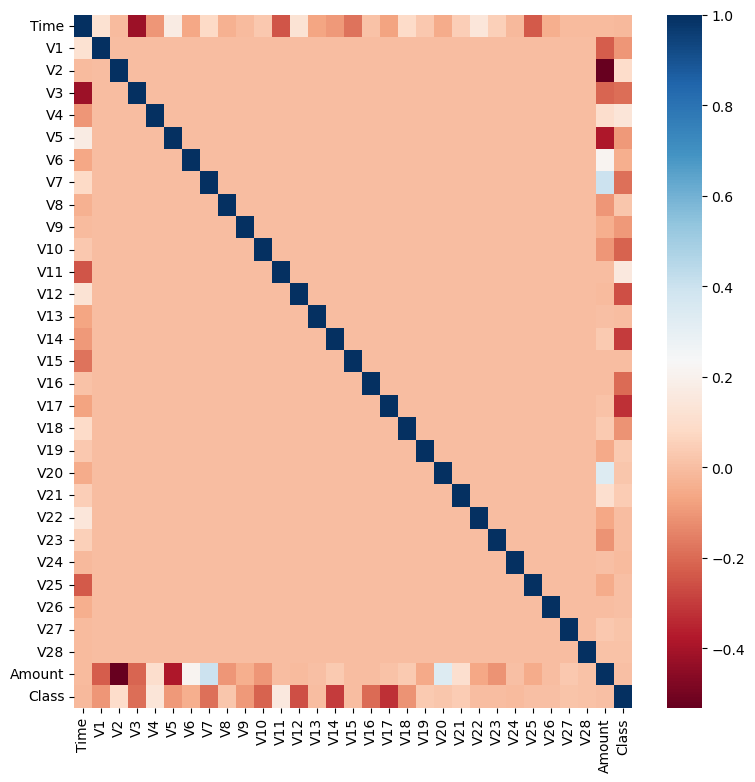

In [27]:
import seaborn as sns
plt.figure(figsize=(9, 9))
corr=card_df.corr()
sns.heatmap(corr, cmap='RdBu')

상관관계 히트맵에서 cmap을 'RdBu'로 설정해 양의 상관관계가 높을수록 색깔이 진한 파란색에 가까우며, 음의 상관관계가 높을수록 색깔이 진한 빨간색에 가깝게 표현된다. 상관관계 히트맵에서 맨 아래에 위치한 결정 레이블인 Class 피처와 음의 상관관계가 가장 높은 피처는 V14와 V17이다. 이 중 V14에 대해서만 이상치를 찾아서 제거해 보겠다. IQR을 이용해 이상치를 검출하는 함수를 생성한 뒤, 이를 이용해 검출된 이상치를 삭제한다. get_outlier() 함수는 인자로 DataFrame과 이상치를 검출한 칼럼을 입력 받는다. 함수 내에서 넘파이의 percentile()을 이용해 1/4 분위와 3/4분위를 구하고, 이에 기반해 IQR을 계산한다. 계산된 IQR에 1.5를 곱해서 최댓값과 최솟값 지점을 구한 뒤, 최댓값보다 크거나 최솟값보다 작은 값을 이상치로 설정하고 해당 이상치가 있는 DataFrame Index를 반환한다.

In [28]:
import numpy as np
def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud=df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values, 25)
    quantile_75=np.percentile(fraud.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최댓값과 최솟값 지점 구함
    iqr=quantile_75-quantile_25
    iqr_weight=iqr*weight
    lowest_val=quantile_25-iqr_weight
    highest_val=quantile_75+iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 DataFrame index 반환
    outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

get_outlier() 함수를 이용해 V14 칼럼에서 이상치 데이터를 찾아보겠다.

In [30]:
outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


총 4개의 데이터인 8296, 8615, 9035, 9252번 Index가 이상치로 추출됐다. get_outlier()를 이용해 이상치를 추출하고 이를 삭제하는 로직을 get_processed_df() 함수에 추가해 데이터를 가공한 뒤 이 데이터 세트를 이용해 로지스틱 회귀와 LightGBM 모델을 다시 적용해 보겠다.

In [32]:
# get_processed_df()를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index=get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712, F1: 0.7597, AUC: 0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85268    27]
 [   36   110]]
정확도: 0.9993, 정밀도: 0.8029, 재현율: 0.7534, F1: 0.7774, AUC: 0.9219


이상치 데이터를 제거한 뒤, 로지스틱 회귀와 LightGBM 모두 예측 성능이 크게 향상되었다. 로지스틱 회귀의 경우 재현율이 60.14%에서 67.12%로 크게 증가했으며, LightGBM의 경우도 47.30%에서 75.34%로 역시 크게 증가했다.

**SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

이번에는 SMOTE 기법으로 오버 샘플링을 적용한 뒤 로지스틱 회귀와 LightGBM 모델의 예측 성능을 평가해 보겠다. 먼저 SMOTE는 앞에서 설치한 imbalanced-learn 패키지의 SMOTE 클래스를 이용해 간단하게 구현이 가능하다. SMOTE를 적용할 때는 반드시 학습 데이터 세트만 오버 샘플링을 해야 한다. 검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링할 경우 결국은 원본 데이터 세트가 아닌 데이터 세트에서 검증 또는 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

앞 예제에서 생성한 학습 피처/레이블 데이터를 SMOTE 객체의 fit_sample() 메서드를 이용해 증식한 뒤 데이터를 증식 전과 비교해 보자.

In [34]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 :\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 :
 Class
0    199020
1    199020
Name: count, dtype: int64


SMOTE 적용 전 학습 데이터 세트는 199,362건이었지만 SMOTE 적용 후 2배에 가까운 398,040건으로 데이터가 증식되었다. 그리고 SMOTE 적용 후 레이블 값이 0과 1의 분포가 동일하게 199,020건으로 생성됐다. 이제 이렇게 생성된 학습 데이터 세트를 기반으로 번저 로지스틱 회귀 모델을 학습한 뒤 성능을 평가해 보겠다.

In [35]:
lr_clf=LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over과 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247, F1: 0.1023, AUC: 0.9737


로지스틱 회귀 모델의 경우 SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 5.4%로 급격하게 저하된다. 재현율이 높더라도 이 정도로 저조한 정밀도로는 현실 업무에 적용할 수 없다. 이는 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무나 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 급격히 떨어지게 된 것이다. 분류 결정 임곗값에 따른 정밀도와 재현율 곡선을 통해 SMOTE로 학습된 로지스틱 회귀 모델에 어떠한 문제가 발생하고 있는지 시각적으로 확인해 보겠다. 이를 위해 3장에서 사용한 precision_recall_curve_plot() 함수를 이용한다.

In [36]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출.
    precisions, recalls, thresholds=precision_recall_curve(y_test, pred_proba_c1)

    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary=thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end=plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    # x축, y축 label과 legned, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

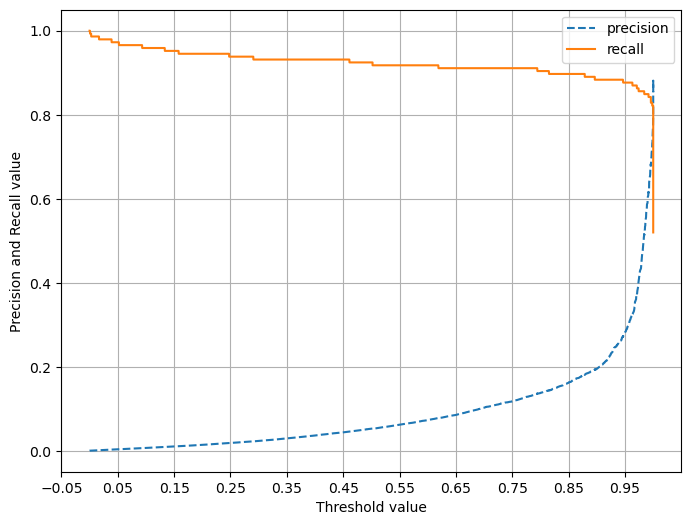

In [37]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임곗값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다. 분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델이 생성되지 못했다. 이번에는 LightGBM 모델을 SMOTE로 오버 샘플링된 데이터 세트로 학습/예측/평가를 수행하겠다.

In [38]:
lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493, F1: 0.8794, AUC: 0.9814


재현율이 이상치만 제거한 경우인 75.34%보다 높은 84.93%가 되었다. SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적이다. 좋은 SMOTE 패키지일수록 재현율 증가율은 높이고 정밀도 감소율은 낮출 수 있도록 효과적으로 데이터를 증식한다.

# 10. 스태킹 앙상블

스태킹(Stacking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는점에서 앞에 소개한 배깅(Bagging) 및 부스팅(Boosting)과 공통점을 가지고 있다. 하지만 가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것이다. 즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식이다(이렇게 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하고 방식을 메타 모델이라고 한다).

스태킹 모델은 두 종류의 모델이 필요하다. 첫 번째는 개별적인 기반 모델이고, 두 번째 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델이다. 스태킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것이다.

스태킹을 현실 모델에 적용하는 경우는 그렇게 많지 않지만, 캐글과 같은 대화에서 높은 순위를 차지하기 위해 조금이라도 성능 수치를 높여야 할 경우 자주 사용된다. 스태킹을 적용할 때는 많은 개별 모델이 필요하다. 2 ~ 3개의 개별 모델만을 결합해서는 쉽게 예측 성능을 향상시킬 수 없으며, 스태킹을 적용한다고 해서 반드시 성능 향상이 되리라는 보장도 없다. 일반적으로 성능이 비슷한 모델을 결합해 좀 더 나은 성능 향상을 도출하기 위해 적용된다.

위에서 언급한 스태킹 모델 개념의 간단한 다이어그램은 옆의 그림과 같다. 여러 개의 모델에 대한 예측값을 합한 후, 즉 스태킹 형태로 쌓은 뒤 이에 대한 예측을 다시 수행하는 것이다.

M 개의 로우, N 개의 피처(칼럼)를 가진 데이터 세트에 스태킹 앙상블을 적용한다고 가정하겠다. 그리고 학습에 사용할 ML 알고리즘 모델은 모두 3개이다. 먼저 모델별로 각각 학습을 시킨 뒤 예측을 수행하면 각각 M개의 로우를 가진 1개의 레이블 값을 도출할 것이다. 모델별로 도출된 예측 레이블 값을 다시 합해서(스태킹) 새로운 데이터 세트를 만들고 이렇게 스태킹된 데이터 세트에 대해 최종 모델을 적용해 최종 예측을 하는 것이 스태킹 앙상블 모델이다.

**기본 스태킹 모델**

새로운 주피터 노트북을 생성하고, 기본 스태킹 모델을 위스콘신 암 데이터 세트에 적용해 보겠다. 데이터를 다시 로딩하고 학습 데이터 세트와 테스트 데이터 세트로 나누겠다.

In [41]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data=load_breast_cancer()

X_data=cancer_data.data
y_label=cancer_data.target

X_train, X_test, y_train, y_test=train_test_split(X_data, y_label, test_size=0.2, random_state=0)

스태킹에 사용될 머신러닝 알고리즘 클래스를 생성한다. 개별 모델은 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트이며, 이들 모델의 예측 결과를 합한 데이터 세트로 학습/예측하는 최종 모델은 로지스틱 회귀이다.

In [42]:
# 개별 ML 모델 생성
knn_clf=KNeighborsClassifier(n_neighbors=4)
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf=DecisionTreeClassifier()
ada_clf=AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final=LogisticRegression(C=10)

개별 모델을 학습하겠다.

In [43]:
# 개별 모델들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

개별 모델의 예측 데이터 세트를 반환하고 각 모델의 예측 정확도를 살펴보겠다.

In [45]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred=knn_clf.predict(X_test)
rf_pred=rf_clf.predict(X_test)
dt_pred=dt_clf.predict(X_test)
ada_pred=ada_clf.predict(X_test)

print('KNN 정확도 : {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도 : 0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9035
에이다부스트 정확도 : 0.9561


개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙어서 피처 값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용하겠다. 반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose()를 이용해 행과 열 위치를 바꾼 ndarray로 변환하면 된다.

In [46]:
pred=np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred=np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


이렇게 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도를 수행하겠다.

In [47]:
lr_final.fit(pred, y_test)
final=lr_final.predict(pred)
print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도 : 0.9737


개별 모델의 예측 데이터를 스태킹으로 재구성해 최종 메타 모델에서 학습하고 예측한 결과, 정확도가 97.37%로 개별 모델 정확도보다 향상되었다(물론 이러한 스태킹 기법으로 예측을 한다고 무조건 개별 모델보다는 좋아진다는 보장은 없다). 이제까지 기본 스태킹 모델의 구성과 적용을 알아봤다. 이번에는 과적합을 개선하기 위한 CV 세트 기반의 스태킹 모델을 살펴보겠다.

**CV 세트 기반의 스태킹**

CV 세트 기반의 스태킹 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용한다. 앞 예제에서 마지막에 메타 모델인 로지스틱 회귀 모델 기반에서 최종 학습할 때 레이블 데이터 세트로 학습 데이터가 아닌 테스트용 레이블 데이터 세트를 기반으로 학습했기에 과적합 문제가 발생할 수 있다.

CV 세트 기반의 스태킹은 이에 대한 개선을 위해 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행한다. 이는 다음과 같이 2단계의 스텝으로 구분될 수 있다.
* 스텝1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성한다.
* 스텝2 : 스텝1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성한다. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성한다. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가한다.

스텝1의 핵심은 개별 모델에서 메타 모델인 2차 모델에서 사용될 학습용 데이터와 테스트용 데이터를 교차 검증을 통해서 생성하는 것이다. 스텝1은 개별 모델 레벨에서 수행하는 것이며, 이러한 로직을 여러 개의 개별 모델에서 동일하게 수행한다.

먼저 학습용 데이터를 N개의 폴드(Fold)로 나눈다. 여기서는 3개의 폴드세트로 가정하겠다. 3개의 폴드 세트이므로 3번의 유사한 반복 작업을 수행하고, 마지막 3번째 반복에서 개별 모델의 예측값으로 학습 데이터와 테스트 데이터를 생성한다. 주요 프로세스는 다음과 같다. 1. 학습용 데이터를 3개의 폴드로 나누되, 2개의 폴드는 학습을 위한 데이터 폴드로, 나머지 1개의 폴드는 검증을 위한 데이터 폴드로 나눈다. 이렇게 두 개의 폴드로 나뉜 학습 데이터를 기반으로 개별 모델을 학습시킨다. 2. 이렇게 학습된 개별 모델은 검증 폴드 1개 데이터로 예측하고 그 결과를 저장한다. 이러한 로직을 3번 반복하면서 학습 데이터와 검증 데이터 세트를 변경해가면서 학습 후 예측 결과를 별도로 저장한다. 이렇게 만들어진 예측 데이터는 메타 모델을 학습시키는 학습 데이터로 사용된다. 한편 3. 2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측하여 예측값을 생성한다. 마찬가지로 이러한 로직을 3번 반복하면서 이 예측값의 평균으로 최종 결괏값을 생성하고 이를 메타 모델을 위한 테스트 데이터로 사용한다. 다음 그림에 스텝 1의 개별 모델이 메타 모델을 위한 학습 데이터와 테스트 데이터를 생성하는 로직을 순차적으로 설명했다.

스텝2는 각 모델들이 스텝1로 생성한 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터를 생성하기만 하면 된다. 메타 모델이 사용할 최종 학습 데이터와 원본 데이터의 레이블 데이터를 합쳐서 메타 모델을 학습한 후에 최종 테스트 데이터로 예측을 수행한 뒤, 최종 예측 결과를 원본 테스트 데이터의 레이블 데이터와 비교해 평가하면 된다.

먼저 스텝1 부분을 코드로 구현하겠다. 앞에서 설명한 대로 개별 모델이 메타 모델을 위한 학습용 데이터와 테스트 데이터를 생성하는 것이다. 먼저 get_stacking_base_datasets() 함수를 생성한다. 이 함수에서는 개별 모델의 Classifier 객체, 원본인 학습용 피처 데이터, 원본인 학습용 레이블 데이터, 원본인 테스트 피처 데이터, 그리고 K 폴드를 몇 개로 할지를 파라미터로 입력받는다. 함수 내에서는 폴드의 개수만큼 반복을 수행하면서 폴드된 학습용 데이터로 학습한 뒤 예측 결괏값을 기반으로 메타 모델을 위한 학습용 데이터와 테스트용 데이터를 새롭게 생성한다.

In [66]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds 값으로 KFold 생성
    kf=KFold(n_splits=n_folds, shuffle=True, random_state=0)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred=np.zeros((X_train_n.shape[0], 1))
    test_pred=np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트 :', folder_counter, '시작')
        X_tr=X_train_n[train_index]
        y_tr=y_train_n[train_index]
        X_te=X_train_n[valid_index]
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index, :]=model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folder_counter]=model.predict(X_test_n)
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean=np.mean(test_pred, axis=1).reshape(-1, 1)
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

이제 여러 개의 분류 모델별로 stack_base_model() 함수를 수행한다. 개별 모델은 앞의 기본 스태킹 모델에서 생성한 KNN, 랜덤 포레스트, 결정 트리, 에이다부스트 모델이며, 이들 모델별로 get_stacking_base_datasets() 함수를 호출해 각각 메타 모델이 추후에 사용할 학습용, 테스트용 데이터 세트를 반환한다.

In [67]:
knn_train, knn_test=get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test=get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test=get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test=get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
RandomForestClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
AdaBoostClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작


스텝2를 구현해 보겠다. 앞의 예제에서 get_stacking_base_datasets() 호출로 반환된 각 모델별 학습 데이터와 테스트 데이터를 합치기만 하면 된다. 넘파이의 concatenate()를 이용해 쉽게 이와 같은 기능을 수행한다. concatenate()는 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐주는 기능을 제공한다.

In [68]:
Stack_final_X_train=np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test=np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape :', X_train.shape, '원본 테스트 피처 Shape :', X_test.shape)
print('스태킹 학습 피처 데이터 Shape :', Stack_final_X_train.shape, '스태킹 테스트 피처 데이터 Shape :', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape : (455, 30) 원본 테스트 피처 Shape : (114, 30)
스태킹 학습 피처 데이터 Shape : (455, 4) 스태킹 테스트 피처 데이터 Shape : (114, 4)


이렇게 만들어진 Stack_final_X_train은 메타 모델이 학습할 학습용 피처 데이터 세트이다. 그리고 Stack_final_X_test는 메타 모델이 예측할 테스트용 피처 데이터 세트이다. 스태킹 학습 피처 데이터는 원본 학습 피처 데이터와 로우(Row) 크기는 같으며, 4개의 개별 모델 예측값을 합친 것이므로 칼럼(Column) 크기는 4이다.

최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후에 스태킹된 테스트 데이터 세트로 예측하고, 예측 결과를 원본 테스트 레이블 데이터와 비교해 정확도를 측정해보겠다.

In [70]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final=lr_final.predict(Stack_final_X_test)
print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도 : 0.9737


최종 메타 모델의 예측 정확도는 약 97.37%로 측정됐다. 지금까지의 예제에서는 개별 모델의 알고리즘에서 파라미터 튜닝을 최적으로 하지 않았지만, 스태킹을 이루는 모델은 최적으로 파라미터를 튜닝한 상태에서 스태킹 모델을 만드는 것이 일반적이다. 여러 병으로 이뤄진 분석 팀에서 개별적으로 각각 모델을 최적으로 학습시켜서 스태킹 모델을 더 빠르게 최적화할 수 있을 것이다. 일반적으로 스태킹 모델의 파라미터 튜닝은 개별 알고리즘 모델의 파라미터를 최적으로 튜닝하는 것을 말한다.

스태킹 모델은 분류(Classification)뿐만 아니라 회귀(Regression)에서도 적용 가능하다. 5장 회귀의 마지막 실습 절에서 스태킹 모델을 활용해 모델의 예측 성능을 개선해보겠다.

# 11. 정리

이번 장에서는 분류를 위해 일반적으로 가장 많이 사용되는 앙상블에 대해서 집중적으로 배워봤다. 대부분의 앙상블 기법은 결정 트리 기반의 다수의 약한 학습기(Weak Learner)를 결합해 변동성을 줄여 예측 오류를 줄이고 성능을 개선하고 있다. 결정 트리 알고리즘은 정보의 균일도에 기반한 규칙 트리를 만들어서 예측을 수행한다. 결정 트리는 다른 알고리즘에 비해 비교적 직관적이어서 어떻게 예측 결과가 도출되었는지 그 과정을 쉽게 알 수 있다. 결정 트리의 단점으로는 균일한 최종 예측 결과를 도출하기 위해 결정 트리가 깊어지고 복잡해지면서 과적합이 쉽게 발생하는 것이다.

앙상블 기법은 대표적으로 배깅과 부스팅으로 구분될 수 있으며, 배깅 방식은 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측하는 방식이다. 대표적인 배깅 방식은 랜덤 포레스트이다. 랜덤 포레스트는 수행 시간이 빠르고 비교적 안정적인 예측 성능을 제공하는 훌륭한 머신러닝 알고리즘이다.

현대의 앙상블 기법은 배깅보다는 부스팅이 더 주류를 이루고 있다. 부스팅은 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음 번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측할 수 있도록 해준다. 부스팅의 효시격인 GBM(Gradient Boosting Machine)은 뛰어난 예측 성능을 가졌지만, 수행 시간이 너무 오래 걸린다는 단점이 있다.

XGBoost와 LightGBM은 현재 가장 각광을 받고 있는 부스팅 기반 머신러닝 패키지이다. XGBoost의 경우 많은 캐글 경연대회에서 우승을 위한 알고리즘으로 불리면서 명성을 쌓아왔으며, LightGBM 또한 XGBoost보다 빠른 학습 수행 시간에도 불구하고 XGBoost에 버금가는 예측 성능을 보유하고 있다. XGBoost와 LightGBM 개발 그룹은 많은 사용자들이 애용하는 사이킷런과 XGBoost와 LightGBM이 쉽게 연동할 수 있도록 사이킷런 래퍼 클래스를 제공하고 있다. 이들 래퍼 클래스를 이용하면 사이킷런의 여타 다른 Estimator 클래스와 동일한 방식으로 사이킷런 기반의 머신러닝 애플리케이션을 더 쉽게 개발할 수 있다.

마지막으로 스태킹 모델을 살펴봤다. 스태킹은 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 데이터 세트를 재생성하는 기법이다. 스태킹 모델의 핵심은 바로 메타 모델이 사용할 학습 데이터 세트와 예측 데이터 세트를 개별 모델의 예측 값들을 스태킹 형태로 결합해 생성하는 데 있다.